In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier

from sklearn.metrics import f1_score, recall_score
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Data

Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud
<br>V1-V28 are variables derived from PCA
<br>No missing values

In [2]:
current_dir = os.getcwd()
data_folder = 'Data'
file_path = os.path.join(current_dir, data_folder, 'compressed_creditcard.csv.zip')
data = pd.read_csv(file_path)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [4]:
# Highly inbalanced dataset
print('Class counts:')
print(data['Class'].value_counts())
print()
print('Class shares:')
print(data['Class'].value_counts(normalize=True))

Class counts:
0    284315
1       492
Name: Class, dtype: int64

Class shares:
0    0.998273
1    0.001727
Name: Class, dtype: float64


Text(0, 0.5, 'amount')

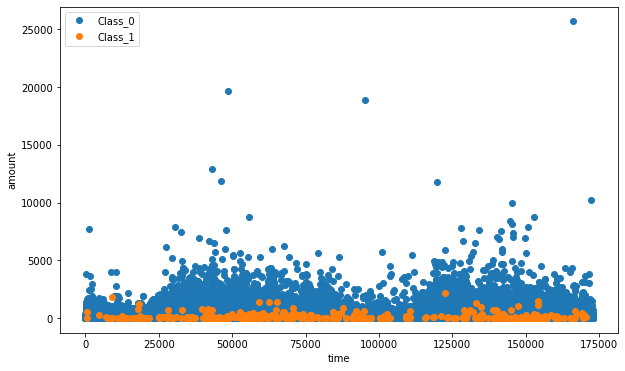

In [5]:
# Amount
groups = data.groupby("Class")
for name, group in groups:
    plt.plot(group["Time"], group["Amount"], marker="o", linestyle="", label='Class' + '_' + str(name))
plt.legend()
plt.xlabel('time')
plt.ylabel('amount')

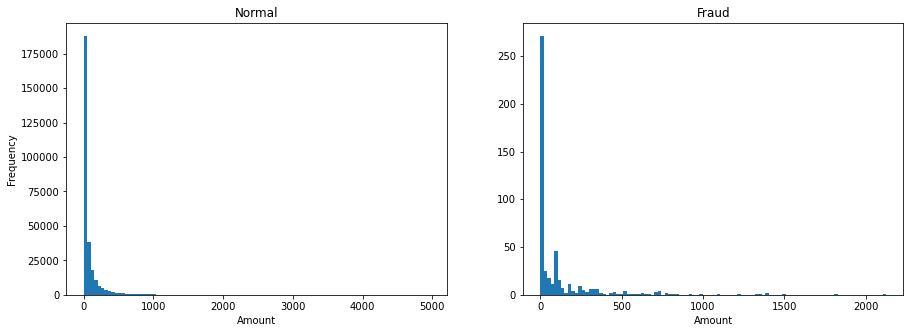

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, figsize = (15,5))
# Distribution of majority Amount point for normal transactions
ax1.hist(data[(data['Class']==0) & (data['Amount']<5000)]['Amount'], bins=100)
ax1.set_title('Normal')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amount')

# Distribution of Amount  for fraudulent transactions
ax2.hist(data[(data['Class']==1)]['Amount'], bins=100)
ax2.set_title('Fraud')
ax2.set_xlabel('Amount')

plt.show()

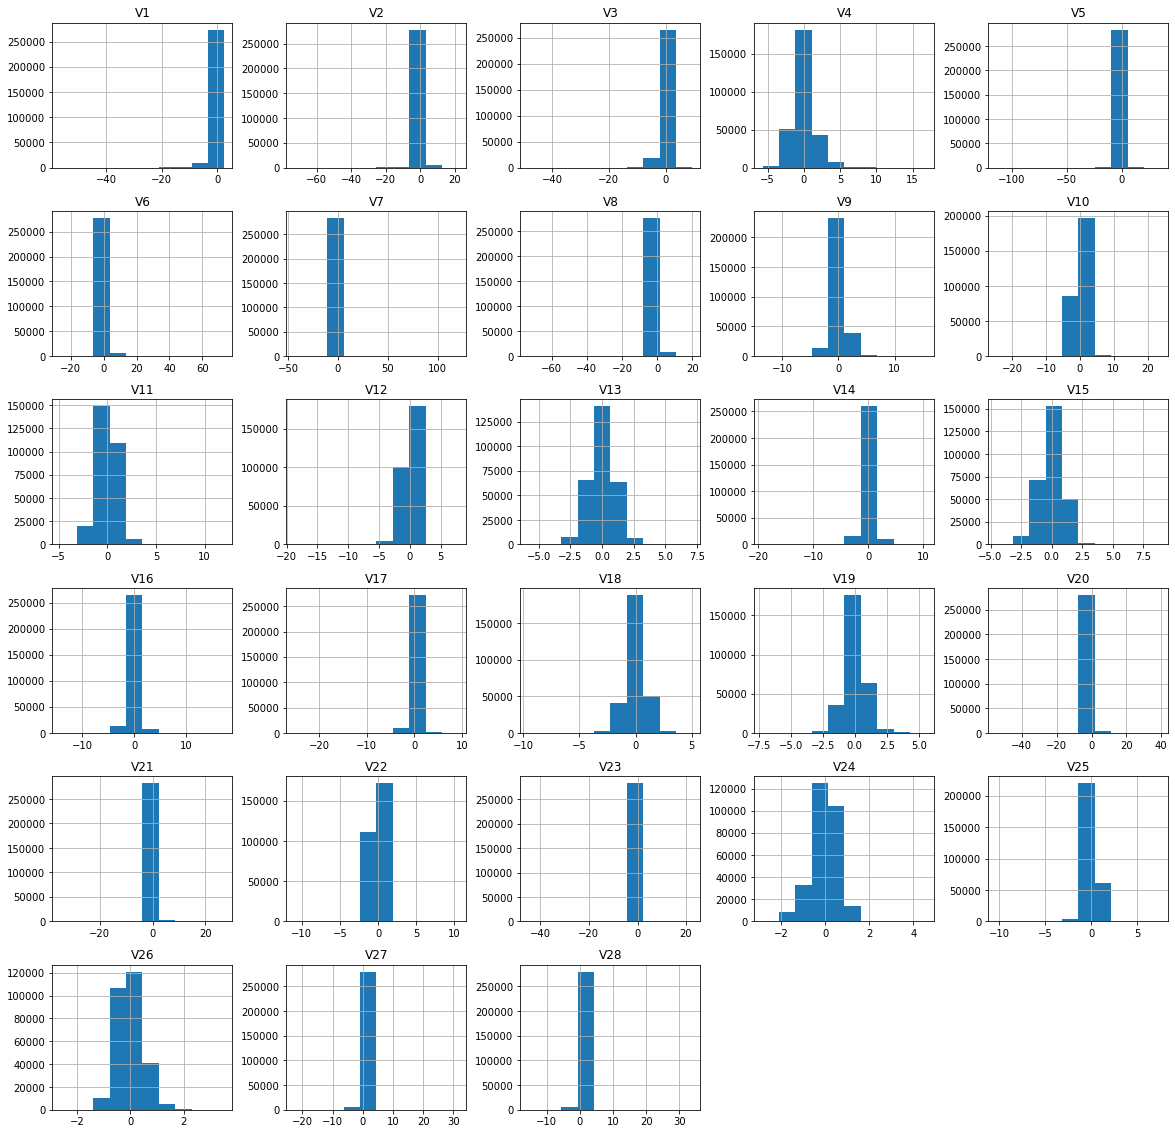

In [7]:
# V1-V28
data.loc[:,'V1':'V28'].hist(figsize = (20,20))
plt.show()

In [8]:
# Correlations with Class:
corrs = {}
for col in data.columns.drop('Class'):
    corrs[col] = data['Class'].corr(data[col])

# Sort corr asc:
{k: v for k, v in sorted(corrs.items(), key=lambda item: abs(item[1]))}

{'V22': 0.0008053175052959087,
 'V23': -0.0026851557402423334,
 'V25': 0.003307705597289396,
 'V15': -0.004223402267843594,
 'V26': 0.004455397501269385,
 'V13': -0.004569778799447076,
 'Amount': 0.005631753006749995,
 'V24': -0.007220906715930302,
 'V28': 0.009536040916206127,
 'Time': -0.012322570929207388,
 'V27': 0.017579728189458178,
 'V8': 0.019875123914733152,
 'V20': 0.02009032419691219,
 'V19': 0.03478301303640624,
 'V21': 0.0404133806104527,
 'V6': -0.043643160699829035,
 'V2': 0.09128865034433539,
 'V5': -0.09497429899115035,
 'V9': -0.09773268607377424,
 'V1': -0.10134729859476974,
 'V18': -0.11148525388869356,
 'V4': 0.1334474862385853,
 'V11': 0.15487564474346413,
 'V7': -0.18725659151371082,
 'V3': -0.1929608270668159,
 'V16': -0.1965389403034051,
 'V10': -0.21688294364035496,
 'V12': -0.2605929248764044,
 'V14': -0.30254369580346246,
 'V17': -0.32648106724269765}

# Models

In [3]:
# Train test split
state = np.random.RandomState(42)
cols = data.columns.drop('Class')
X = data[cols]
y = data['Class']
print('X shape', X.shape)
print('y shape', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state, stratify=y)
print()
print('X train shape', X_train.shape)
print('X test shape', X_test.shape)

print()
class1_train = len(y_train[y_train==1])/len(y_train[y_train==0])
class1_test = len(y_test[y_test==1])/len(y_test[y_test==0])
print('Share of Class 1 in train:', class1_train)
print('Share of Class 1 in test:', class1_test)

X shape (284807, 30)
y shape (284807,)

X train shape (213605, 30)
X test shape (71202, 30)

Share of Class 1 in train: 0.0017304770301450037
Share of Class 1 in test: 0.0017304689148693708


## Isolation Forest

In [10]:
# Base model
isfor = IsolationForest(contamination = class1_train, random_state = state, bootstrap = True)

In [11]:
# Isfor returns 1 for normal data and -1 for outliers. Function to adjust the labels:
def adjust_labels(s):
    s[s==1]=0
    s[s==-1]=1
    return s

In [12]:
# Tuning n_estimators based on highest recall on test set
n_est = [100, 300, 500]
for n in n_est:
    print('N estimators', n)
    
    isfor.set_params(n_estimators = n)
    isfor.fit(X_train)
    
    y_fit = isfor.predict(X_train)    
    y_pred = isfor.predict(X_test)
    
    adjust_labels(y_fit)
    adjust_labels(y_pred)
    
    print('Train fit')
    print(classification_report(y_train, y_fit))
    
    print('Test fit')
    print(classification_report(y_test, y_pred))

# n_estimators of 700 or 1000 did not give higher recall. Best n_estimators = 300 or 500

N estimators 100
Train fit
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.26      0.26      0.26       369

    accuracy                           1.00    213605
   macro avg       0.63      0.63      0.63    213605
weighted avg       1.00      1.00      1.00    213605

Test fit
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.24      0.24      0.24       123

    accuracy                           1.00     71202
   macro avg       0.62      0.62      0.62     71202
weighted avg       1.00      1.00      1.00     71202

N estimators 300
Train fit
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213236
           1       0.25      0.25      0.25       369

    accuracy                           1.00    213605
   macro avg       0.62      0.62      0.62    213605
weighted av

Best isfor model has recall on test set 0.24-0.27. So max 27% of all real fraud transactions get detected. Not very high.

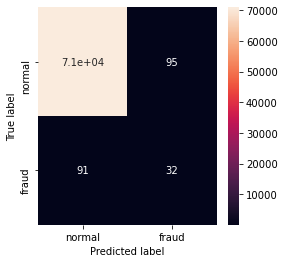

In [13]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_conf_matrix():
    cm = confusion_matrix(y_test, y_pred) 
    # Transform to df for easier plotting
    cm_df = pd.DataFrame(cm,
                     index = ['normal','fraud'], 
                     columns = ['normal','fraud'])

    plt.figure(figsize=(4,4))
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.show()

plot_conf_matrix()

## Gradient boosting

In [14]:
# Base model
gbc = GradientBoostingClassifier(random_state=state, min_weight_fraction_leaf=0.1)
gbc.fit(X_train, y_train, sample_weight=10)

y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.81      0.73      0.77       123

    accuracy                           1.00     71202
   macro avg       0.91      0.87      0.88     71202
weighted avg       1.00      1.00      1.00     71202



In [15]:
# Tuning parmeters

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import forest_minimize
from sklearn.metrics import f1_score, recall_score

space  = [Integer(100, 500, name='n_estimators'),
          Real(0.0001, 0.1, "uniform", name='learning_rate'),
          Real(0.1, 1.0, "uniform", name='subsample'),
          Real(0.1, 1.0, "uniform", name='max_features'),
          Real(0.01, 0.5, "uniform", name='min_weight_fraction_leaf')
         ]

@use_named_args(space)
def objective(**params):
    gbc.set_params(**params)
    return -np.mean(cross_val_score(gbc, X_train, y_train, cv=3, scoring="recall", n_jobs=-1))

# WARNING: runs several hours
# results = forest_minimize(objective, space, n_calls=50, n_random_starts=5)
# #results = gp_minimize(objective, space, n_calls=50, n_random_starts=5)
# best_metric = results.fun
# best_params = results.x

# print('Best metric:', -1*best_metric)
# print('Best params:', best_params)
print('Best metric:', 0.7886178861788617)
print('Best params:', [436, 0.09324306027671825, 0.7053855928128382, 0.38521969128922096, 0.08133634149444764])


Best metric: 0.7886178861788617
Best params: [436, 0.09324306027671825, 0.7053855928128382, 0.38521969128922096, 0.08133634149444764]


In [16]:
#Best metric: 0.7886178861788617
#Best params: [436, 0.09324306027671825, 0.7053855928128382, 0.38521969128922096, 0.08133634149444764]

In [17]:
# FITTING MODEL WITH BEST FOUND PARAMETERS
gbc.set_params(n_estimators=436, learning_rate=0.09, subsample=0.71, max_features=0.39, min_weight_fraction_leaf=0.08)
gbc.fit(X_train, y_train, sample_weight=10)

y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.93      0.76      0.84       123

    accuracy                           1.00     71202
   macro avg       0.97      0.88      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [18]:
# Tuning parmeters round 2

gbc.set_params(subsample=0.7, max_features=0.4)

space  = [Integer(100, 500, name='n_estimators'),
          Real(0.05, 0.2, "uniform", name='learning_rate'),
          Real(0.01, 0.1, "uniform", name='min_weight_fraction_leaf')
         ]

@use_named_args(space)
def objective(**params):
    gbc.set_params(**params)
    return -np.mean(cross_val_score(gbc, X_train, y_train, cv=3, scoring="recall", n_jobs=-1))

# # Takes a while to run. Commenting out.
# results = forest_minimize(objective, space, n_calls=10, n_random_starts=2, n_jobs=-1)
# #results = gp_minimize(objective, space, n_calls=50, n_random_starts=5)
# best_metric = results.fun
# best_params = results.x

# print('Best metric:', -1*best_metric)
# print('Best params:', best_params)
print('Best metric:', 0.7886178861788617)
print('Best params:', [305, 0.06303772967981788, 0.09114996243159758])


Best metric: 0.7886178861788617
Best params: [305, 0.06303772967981788, 0.09114996243159758]


In [19]:
# FITTING MODEL WITH BEST FOUND PARAMETERS IN ROUND 2
gbc.set_params(n_estimators=305, learning_rate=0.06, subsample=0.7, max_features=0.4, min_weight_fraction_leaf=0.09)
gbc.fit(X_train, y_train, sample_weight=10)

y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.89      0.76      0.82       123

    accuracy                           1.00     71202
   macro avg       0.94      0.88      0.91     71202
weighted avg       1.00      1.00      1.00     71202



In [20]:
# No big difference from round 1, but in general improvement in recall from the base model. 

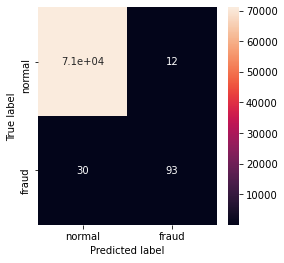

In [21]:
# CONFUSION MATRIX FOR GBC
plot_conf_matrix()

## Autoencoders

Idea: model normal transactions only. When reconstructing input, the error will be largest on fraudulent transactions.

In [54]:
# Train set - keep only normal transactions
X_train2 = X_train.copy()
X_train2['y'] = y_train
X_train2 = X_train2[X_train2['y']==0]
X_train2 = X_train2.drop('y',axis=1)

X_train2, X_test2 = train_test_split(X_train2, test_size=0.2, random_state=state)
print('X train 2 normal shape', X_train2.shape)
print('X test 2 normal shape', X_test2.shape)


# Test set - keep as is for validation (includes both normal and fraudulent transactions)
X_valid = X_test.copy()

X train 2 normal shape (170588, 30)
X test 2 normal shape (42648, 30)


In [55]:
# Scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler1 = MinMaxScaler()
X_train_scaled = scaler1.fit_transform(X_train2)
X_test_scaled = scaler1.transform(X_test2)

scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

In [90]:
# Model 1: normalized input
from tensorflow import keras
from tensorflow.keras import layers, regularizers

n_cols = X_train_scaled.shape[1]
n_units = 20

input_layer = keras.Input(shape=(n_cols,))
encoded = layers.Dense(n_units, activation='relu')(input_layer)

encoded = layers.Dense(n_units//2, activation='relu')(encoded)
encoded = layers.Dense(n_units//4, activation='relu')(encoded)

decoded = layers.Dense(n_units//2, activation='relu')(encoded)
decoded = layers.Dense(n_units, activation='relu')(decoded)
decoded = layers.Dense(n_cols, activation='linear')(decoded) # sigmoid is tested, performance slightly wors on anomaly detection

autoencoder1 = keras.Model(input_layer, decoded)
autoencoder1.compile(optimizer='adam', loss='mean_squared_error')

autoencoder1.fit(X_train_scaled, X_train_scaled,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                verbose=1)

Train on 170588 samples, validate on 42648 samples
Epoch 1/10
170588/170588 [==============================] - 3s 20us/sample - loss: 0.0169 - val_loss: 0.0018
Epoch 2/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 3/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0017 - val_loss: 0.0016
Epoch 4/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 5/10
170588/170588 [==============================] - 2s 14us/sample - loss: 0.0016 - val_loss: 0.0016
Epoch 6/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 7/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0015 - val_loss: 0.0015
Epoch 8/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 9/10
170588/170588 [==============================] - 2s 13us/sample - 

In [40]:
# Model 2: standardized input

autoencoder2 = keras.Model(input_layer, decoded)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')

autoencoder2.fit(X_train_scaled2, X_train_scaled2,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_scaled2, X_test_scaled2),
                verbose=1)

# Standardized input performes much worse than normalized. Might be due to relu on the first layer.

Train on 170588 samples, validate on 42648 samples
Epoch 1/10
170588/170588 [==============================] - 3s 16us/sample - loss: 0.7939 - val_loss: 0.6998
Epoch 2/10
170588/170588 [==============================] - 2s 12us/sample - loss: 0.6694 - val_loss: 0.6395
Epoch 3/10
170588/170588 [==============================] - 2s 12us/sample - loss: 0.6302 - val_loss: 0.6158
Epoch 4/10
170588/170588 [==============================] - 2s 12us/sample - loss: 0.6099 - val_loss: 0.6137
Epoch 5/10
170588/170588 [==============================] - 2s 12us/sample - loss: 0.5994 - val_loss: 0.5897
Epoch 6/10
170588/170588 [==============================] - 2s 14us/sample - loss: 0.5849 - val_loss: 0.5762
Epoch 7/10
170588/170588 [==============================] - 2s 13us/sample - loss: 0.5755 - val_loss: 0.5919
Epoch 8/10
170588/170588 [==============================] - 2s 12us/sample - loss: 0.5664 - val_loss: 0.5596
Epoch 9/10
170588/170588 [==============================] - 2s 12us/sample - 

In [91]:
# Control
pred_test = autoencoder1.predict(X_test_scaled)
np.mean(np.mean((X_test_scaled-pred_test)**2, axis=1))

0.0014011967779833142

In [92]:
# Validation
X_valid_scaled = scaler1.transform(X_valid)
X_pred = autoencoder1.predict(X_valid_scaled)
X_mse = np.mean((X_valid_scaled-X_pred)**2, axis=1)
result_df = pd.DataFrame({'X_mse':X_mse, 'y':y_test})
print('Normal transactions:')
print(result_df[result_df['y']==0][['X_mse']].describe())

print('Fraud transactions:')
print(result_df[result_df['y']==1][['X_mse']].describe())

print('All transactions:')
print(result_df[['X_mse']].describe())

# Insight: the patterns are difficult to separate as mse distribution is much overlapping btw normal and fraud transactions

Normal transactions:
              X_mse
count  71079.000000
mean       0.001409
std        0.001504
min        0.000110
25%        0.000740
50%        0.001128
75%        0.001738
max        0.081728
Fraud transactions:
            X_mse
count  123.000000
mean     0.024338
std      0.026292
min      0.000542
25%      0.006115
50%      0.013423
75%      0.035114
max      0.095934
All transactions:
              X_mse
count  71202.000000
mean       0.001449
std        0.002086
min        0.000110
25%        0.000740
50%        0.001129
75%        0.001741
max        0.095934


In [93]:
# Anomaly detection
# Otpimizing the error threshold on initial X_train (with both normal and fraud transactions) - based on total error distribution
train_scaled = scaler1.transform(X_train)
train_pred = autoencoder1.predict(train_scaled)
train_mse = np.mean((train_scaled-train_pred)**2, axis=1)
# train_df = pd.DataFrame({'train_mse':train_mse, 'y':y_train})
from sklearn.metrics import f1_score, recall_score, precision_score
for i in range(95,100):
    t = np.quantile(train_mse, i/100)
    y_pred = [1 if e>t else 0 for e in train_mse]
    f_score = f1_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)
    rcl = recall_score(y_train, y_pred)
    print(t, f_score, prec, rcl)

0.003071929283885837 0.059004524886877824 0.030521486752176762 0.8834688346883469
0.003301981975575679 0.07224590531747813 0.03768285547103569 0.8726287262872628
0.0036247232425168857 0.09294777220419002 0.04914963332813231 0.8536585365853658
0.004152800658022956 0.13183972425678586 0.07161245026913175 0.8292682926829268
0.005546029937288444 0.2354349561053472 0.1380439868975199 0.7994579945799458


In [94]:
# Anomaly detection
# Otpimizing the error threshold - based on error for normal transactions (in test - out of sample to allow for higher error)
# Full train dataset (with both normal and fraud) is used for optimizing f1 & recall as fraud is unseen by the model

test_normal_pred = autoencoder1.predict(X_test_scaled)
test_normal_mse = np.mean((X_test_scaled-test_normal_pred)**2, axis=1)
mean_mse = np.mean(test_normal_mse)
std_mse = np.std(test_normal_mse)

train_scaled = scaler1.transform(X_train)
train_pred = autoencoder1.predict(train_scaled)
train_mse = np.mean((train_scaled-train_pred)**2, axis=1)

for i in range(1,10):
    t = mean_mse + i*std_mse
    y_pred = [1 if e>t else 0 for e in train_mse]
    f_score = f1_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)
    rcl = recall_score(y_train, y_pred)
    print(i, f_score, prec, rcl)

1 0.04861470262282971 0.024988607018076866 0.8915989159891599
2 0.14779038879497708 0.08112407211028633 0.8292682926829268
3 0.2523850823937554 0.1502323180175529 0.7886178861788617
4 0.3163841807909604 0.20588235294117646 0.6829268292682927
5 0.36263736263736257 0.25524861878453037 0.6260162601626016
6 0.4192634560906515 0.3217391304347826 0.6016260162601627
7 0.44654088050314467 0.3641025641025641 0.5772357723577236
8 0.46153846153846156 0.4146868250539957 0.5203252032520326
9 0.45691906005221933 0.44080604534005036 0.4742547425474255


In [95]:
# Validation set
# f1 score is highest with t=8*std and best balance btw precision (less false positives) and recall
t = mean_mse + 8*std_mse

X_valid_scaled = scaler1.transform(X_valid)
X_pred = autoencoder1.predict(X_valid_scaled)
X_mse = np.mean((X_valid_scaled-X_pred)**2, axis=1)

y_pred = [1 if e>t else 0 for e in X_mse]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.40      0.51      0.45       123

    accuracy                           1.00     71202
   macro avg       0.70      0.76      0.72     71202
weighted avg       1.00      1.00      1.00     71202



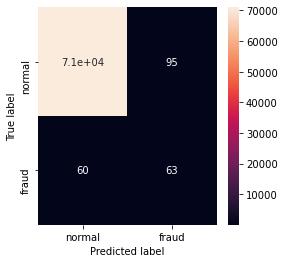

In [101]:
plot_conf_matrix()

# Conclusion

For the given dataset with no additional feature engineering there is a large performance difference between different models. In our datasets fraud transaction patterns appear to be non-lenear and not easily separated from normal transactions. This could be the reason behind quite poor performance for both Isolation Forest and Autoencoders. GBM performs the best reaching precision of 0.89, reacall of 0.76 and f1 score of 0.82. 